# Import

In [1]:
!pip install imbalanced-learn
import imblearn
print(imblearn.__version__)

0.12.4


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns
import statistics
import math as m

# import necessary packages
import pandas as pd
from copy import deepcopy as copy
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch import save as torch_save
from sklearn import datasets
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix

# MODEL CREATION
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# RNN Training and Testing

## EDA

In [4]:
data_dir = "/content/drive/MyDrive/MS thesis"
x = "/content/drive/MyDrive/MS thesis/preliminary site selection/RG1/rg1-clusters.csv"
rg1n_clustered_df = pd.read_csv(x)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster
0,0,2865422,Ilio-ilio (Iliw-iliw),Burgos,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.166831,1.0,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0
1,1,2866789,Macaboboni,Agno,Pangasinan,1.147061,0.556495,4.096106,1.518058,2.013981,...,1.180281,1.0,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0.0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0.0,0,0,0,2877844,12.122822,2866791,0.397831,0.0
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,1.221725,0.0,0,0,1,2877844,15.836811,2866795,0.421410,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1.0,0,0,1,2971664,20.940640,2992394,0.545943,1.0
5725,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1.0,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0
5726,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1.0,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0
5727,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1.0,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0


## Balance data
- this is so the model is properly trained with a more distributed set of data with 0s and 1s.


1. Downsampling data: to remove unbuildable areas
2. Dataframe set up: normalizing data
3. Upsampling data: generate data points with '1' label (just to teach the model)
4. Get low accessible areas (to turn into Candidate Sites)


### Downsampling

In [5]:
print(rg1n_clustered_df.shape)
print(rg1n_clustered_df['RHU_Presence'].unique())
print(rg1n_clustered_df['Cluster'].unique())
buildable = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
buildable

(5729, 23)
[0 1]
[ 0.  1. nan]


,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster
223,223,2877844,Arwas,Bani,Pangasinan,59.296404,51.271190,300.048330,114.580094,156.934760,...,1.192633,1.0,1,1,0,2877844,0.0,"2877844, 2877845, 2876462, 2877845, 2877844, 2...",0.567438,1.0
278,278,2880597,Arnedo,Bolinao,Pangasinan,865.707140,524.250810,3529.817176,1252.451590,1738.954892,...,0.996167,0.0,1,1,1,2880597,0.0,"2880597, 2879215, 2880596, 2880597, 2880596, 2...",0.518090,0.0
808,808,2901348,Poblacion,Sual,Pangasinan,229.101720,115.704960,947.569080,352.020240,473.207400,...,1.504035,1.0,1,1,1,2901348,0.0,"2901348, 2901347, 2899967, 2899967, 2899966",0.605965,1.0
1114,1114,2919329,Bayaoas,Aguilar,Pangasinan,222.779118,119.541209,816.214631,298.288074,387.871912,...,1.509586,0.0,1,1,1,2919329,0.0,"2919329, 2917947, 2919329, 2917946, 2919328, 2...",0.491393,0.0
1361,1361,2927582,Las-ud,Caba,La Union,389.477498,445.587003,2312.098299,859.714161,1196.261887,...,1.307303,NaN,1,1,1,2927582,0.0,"2927582, 2927581, 2926199, 2927582, 2926199, 2...",NaN,NaN
1419,1419,2928944,Lisqueb,Bacnotan,La Union,328.063958,392.244928,1944.965636,692.946373,1027.399395,...,1.304607,0.0,1,1,1,2928944,0.0,"2928944, 2928945, 2928945, 2928945, 2928945, 2...",0.486347,0.0
1451,1451,2928986,Bonuan Gueset,City of Dagupan,Pangasinan,510.033639,281.836741,2180.625811,842.376806,1125.479069,...,1.158837,0.0,1,1,1,2928986,0.0,"2928986, 2928986, 2928987, 2927605, 2928986, 2...",0.499150,0.0
1546,1546,2930381,Magtaking,City of San Carlos,Pangasinan,601.460730,503.996338,3036.859396,1217.282450,1509.688360,...,1.456397,0.0,1,1,1,2930381,0.0,"2930381, 2930380, 2931763, 2931762, 2931763, 2...",0.497310,0.0
1647,1647,2933032,Buquig,Bantay,Ilocos Sur,483.609997,516.276993,2591.219122,891.067650,1328.176330,...,1.268487,0.0,1,1,1,2933032,0.0,"2933032, 2933033, 2933032, 2933031, 2933033, 2...",0.514415,0.0
1648,1648,2933033,Barangay III (Pob.),City of Vigan,Ilocos Sur,1152.388301,1180.214626,6313.541875,2368.987015,3295.913575,...,1.335638,0.0,1,1,1,2933033,0.0,"2933033, 2933033, 2933033, 2933034, 2933033, 2...",0.485928,0.0


In [6]:
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True) # DROP NANS so it doesnt interfere with the pcf calculations
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int) # CONVERT LAND COV COL INTO INT FROM FLOAT
high_clustered = rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 1]
high_clustered['buildability_landcov'].unique()
rg1n_clustered_df[rg1n_clustered_df['Cluster'] == 0]

''' If ever non buildable values come out for clusters with 1, change their values to buildable '''
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [1]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [1]

' If ever non buildable values come out for clusters with 1, change their values to buildable '

In [7]:
'''DROP NON-BUILDABLE AREAS'''
non_buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 0]
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['buildability_landcov'] == 0], inplace = True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster
0,0,2865422,Ilio-ilio (Iliw-iliw),Burgos,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.166831,1,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0
1,1,2866789,Macaboboni,Agno,Pangasinan,1.147061,0.556495,4.096106,1.518058,2.013981,...,1.180281,1,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,1.221725,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0
5725,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0
5726,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0
5727,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0


In [8]:
print(rg1n_clustered_df)
print(non_buildable)
print(rg1n_clustered_df['RHU_Presence'].unique())
non_buildable

      Unnamed: 0       ID          barangay_name  city_name province_name  \
0              0  2865422  Ilio-ilio (Iliw-iliw)     Burgos    Pangasinan   
1              1  2866789             Macaboboni       Agno    Pangasinan   
2              2  2866790             Macaboboni       Agno    Pangasinan   
3              3  2866791             Macaboboni       Agno    Pangasinan   
4              4  2866795                Aloleng       Agno    Pangasinan   
...          ...      ...                    ...        ...           ...   
5724        5724  2992394               Pasaleng   Pagudpud  Ilocos Norte   
5725        5725  2992395               Pasaleng   Pagudpud  Ilocos Norte   
5726        5726  2992396           Adams (Pob.)      Adams  Ilocos Norte   
5727        5727  2992397           Adams (Pob.)      Adams  Ilocos Norte   
5728        5728  2992418             Santo Nino  Nueva Era  Ilocos Norte   

      popden_chi  popden_eld  popden_wom  popden_you  popden_w_1  ...  \
0 

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,1.221725,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0
5,5,2866796,Magsaysay,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.119130,0,0,0,0,2877844,16.685262,2866796,0.417061,0.0
16,16,2868165,Centro Toma,Bani,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.152046,0,0,0,0,2877844,11.842269,"2868165, 2868166, 2869548, 2869547, 2868165, 2...",0.401981,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5607,5607,2986875,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,0,0,0,0,2971664,21.935870,"2986875, 2986874, 2985494",0.410242,0.0
5608,5608,2986876,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,0,0,0,0,2971664,23.129615,"2986876, 2986875, 2985495, 2986877, 2985495, 2...",0.410242,0.0
5609,5609,2986877,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,0,0,0,0,2971664,24.376666,"2986877, 2986876, 2985495, 2986877, 2985496, 2...",0.410242,0.0
5634,5634,2986902,Santo Nino,Nueva Era,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.491996,0,0,0,0,2977219,18.596064,"2986902, 2986903",0.384790,0.0


In [9]:
rg1n_clustered_df = rg1n_clustered_df.reset_index(drop=True)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster
0,0,2865422,Ilio-ilio (Iliw-iliw),Burgos,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.166831,1,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0
1,1,2866789,Macaboboni,Agno,Pangasinan,1.147061,0.556495,4.096106,1.518058,2.013981,...,1.180281,1,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.180281,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,1.221725,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0
4688,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797894,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0
4689,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0
4690,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.791358,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0


### DF Set-up
- Data is normalized

In [10]:
rg1n_clustered_df.columns

Index(['Unnamed: 0', 'ID', 'barangay_name', 'city_name', 'province_name',
       'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
       'popden_all', 'flood_probability_value', 'rain intensity_value',
       'drought_value', 'buildability_landcov', 'RHU_Presence',
       'Road_Presence', 'POI_Presence', 'Nearest_RHU',
       'Distance_to_Nearest_RHU_km', 'Neighbors', 'HCFAI', 'Cluster'],
      dtype='object')

In [11]:
'''AGGREGATING THE POPULATION'''
# Assuming df is your DataFrame
vp =  rg1n_clustered_df['popden_chi'] + rg1n_clustered_df['popden_eld'] + rg1n_clustered_df['popden_wom'] + rg1n_clustered_df['popden_you'] + rg1n_clustered_df['popden_w_1'] + rg1n_clustered_df['popden_you']
gen = rg1n_clustered_df['popden_all'] - vp
all = vp + gen
rg1n_clustered_df['total_population'] = all
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster,total_population
0,0,2865422,Ilio-ilio (Iliw-iliw),Burgos,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0,31.231658
1,1,2866789,Macaboboni,Agno,Pangasinan,1.147061,0.556495,4.096106,1.518058,2.013981,...,1,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0,130.432307
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0,216.666771
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0,326.184778
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0,57.582954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0,16.540533
4688,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0,9.480127
4689,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0,6.607602
4690,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0,0.943759


In [12]:
rg1n_clustered_df.loc[rg1n_clustered_df['total_population'] == 0]
# Drop rows with NaN values
rg1n_clustered_df.dropna(inplace=True)
# x_normalized.dropna(inplace=True)

# Convert column 'x14' from float to int
rg1n_clustered_df['buildability_landcov'] = rg1n_clustered_df['buildability_landcov'].astype(int)
rg1n_clustered_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster,total_population
0,0,2865422,Ilio-ilio (Iliw-iliw),Burgos,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0,31.231658
1,1,2866789,Macaboboni,Agno,Pangasinan,1.147061,0.556495,4.096106,1.518058,2.013981,...,1,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0,130.432307
2,2,2866790,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0,216.666771
3,3,2866791,Macaboboni,Agno,Pangasinan,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0,326.184778
4,4,2866795,Aloleng,Agno,Pangasinan,8.135755,5.317485,31.904920,11.086960,14.915550,...,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0,57.582954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0,16.540533
4688,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0,9.480127
4689,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0,6.607602
4690,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0,0.943759


In [13]:
numeric_rg1_clustered_df = rg1n_clustered_df.drop(['barangay_name', 'city_name', 'province_name', 'Unnamed: 0'], axis=1)
numeric_rg1_clustered_df

,ID,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster,total_population
0,2865422,0.000000,0.000000,0.000000,0.000000,0.000000,31.231658,0.934144,1.178482,1.166831,1,0,0,0,2877844,29.847534,"2865422, 2866804",0.506190,0.0,31.231658
1,2866789,1.147061,0.556495,4.096106,1.518058,2.013981,130.432307,0.734487,1.099466,1.180281,1,0,0,0,2877844,11.042224,"2866789, 2866790",0.514707,0.0,130.432307
2,2866790,0.000000,0.000000,0.000000,0.000000,0.000000,216.666771,0.734487,1.099466,1.180281,0,0,0,0,2877844,11.392127,"2866790, 2866791",0.397823,0.0,216.666771
3,2866791,0.000000,0.000000,0.000000,0.000000,0.000000,326.184778,0.734487,1.099466,1.180281,0,0,0,0,2877844,12.122822,2866791,0.397831,0.0,326.184778
4,2866795,8.135755,5.317485,31.904920,11.086960,14.915550,57.582954,1.089602,1.154037,1.221725,0,0,0,1,2877844,15.836811,2866795,0.421410,0.0,57.582954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,2992394,0.000000,0.000000,0.000000,0.000000,0.000000,16.540533,1.438344,2.648136,0.797894,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0,16.540533
4688,2992395,0.000000,0.000000,0.000000,0.000000,0.000000,9.480127,1.438344,2.648136,0.797894,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0,9.480127
4689,2992396,0.000000,0.000000,0.000000,0.000000,0.000000,6.607602,0.591382,2.749202,0.791358,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0,6.607602
4690,2992397,0.000000,0.000000,0.000000,0.000000,0.000000,0.943759,0.591382,2.749202,0.791358,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0,0.943759


In [14]:
# df1[df1['RHU_Presence']==0]
# Count the number of unique values in column 'A'
unique_count = numeric_rg1_clustered_df['Cluster'].nunique()
print("Number of unique values in column 'Cluster':", unique_count)

Number of unique values in column 'Cluster': 2


In [15]:
numeric_rg1_clustered_df.Cluster.unique()
df1 = numeric_rg1_clustered_df[numeric_rg1_clustered_df.isna().any(axis=1)]

df1.loc[df1['RHU_Presence'] == 1, 'buildability_landcov'] = 1
numeric_rg1_clustered_df.loc[numeric_rg1_clustered_df['RHU_Presence'] == 1, 'buildability_landcov'] = 1 # CHANGING AREAS WITH RHUS HAVE A BUILDABILITY SCORE OF 1

In [16]:
# Making id_template for retrieving hex id numbers in the future
id_template = numeric_rg1_clustered_df.astype({'ID' : 'int'})
id_template = id_template.filter(['ID'])
# id_template
y_sample_id = numeric_rg1_clustered_df.filter(['ID', 'Cluster'])
y_sample_id

,ID,Cluster
0,2865422,0.0
1,2866789,0.0
2,2866790,0.0
3,2866791,0.0
4,2866795,0.0
...,...,...
4687,2992394,1.0
4688,2992395,1.0
4689,2992396,1.0
4690,2992397,0.0


In [17]:
y_sample_id[y_sample_id["Cluster"] == 0]

,ID,Cluster
0,2865422,0.0
1,2866789,0.0
2,2866790,0.0
3,2866791,0.0
4,2866795,0.0
...,...,...
4681,2991037,0.0
4682,2991038,0.0
4683,2991039,0.0
4690,2992397,0.0


In [18]:
for i in numeric_rg1_clustered_df.columns:
  print(i)

ID
popden_chi
popden_eld
popden_wom
popden_you
popden_w_1
popden_all
flood_probability_value
rain intensity_value
drought_value
buildability_landcov
RHU_Presence
Road_Presence
POI_Presence
Nearest_RHU
Distance_to_Nearest_RHU_km
Neighbors
HCFAI
Cluster
total_population


In [19]:
x = numeric_rg1_clustered_df.loc[:, ~numeric_rg1_clustered_df.columns.isin(['ID', 'RHU_Presence', 'buildability_landcov',
                                                                            'POI_Presence', 'Road_Presence', 'Nearest_RHU',
                                                                            'Neighbors', 'Cluster'
                                                                            ])]
x_normalized = (x - x.min()) / (x.max() - x.min())
x_normalized

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012161,0.402351,0.362303,0.529227,0.217345,0.200736,0.012161
4,0.002642,0.002460,0.002242,0.001977,0.002021,0.002147,0.598603,0.381557,0.585622,0.283932,0.274284,0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000617,0.791333,0.908729,0.008894,0.375436,0.662741,0.000617
4688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000353,0.791333,0.908729,0.008894,0.375438,0.662741,0.000353
4689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000246,0.323265,0.944389,0.000000,0.377095,0.758678,0.000246
4690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.323265,0.944389,0.000000,0.379822,0.612225,0.000035


In [20]:
x_normalized['RHU_Presence'] = numeric_rg1_clustered_df['RHU_Presence']
x_normalized['ID'] = numeric_rg1_clustered_df['ID']
x_normalized['buildability_landcov'] = numeric_rg1_clustered_df['buildability_landcov']
x_normalized['Road_Presence'] = numeric_rg1_clustered_df['Road_Presence']
x_normalized['POI_Presence'] = numeric_rg1_clustered_df['POI_Presence']
x_normalized['Nearest_RHU'] = numeric_rg1_clustered_df['Nearest_RHU']
x_normalized['Neighbors'] = numeric_rg1_clustered_df['Neighbors']
x_normalized['Cluster'] = numeric_rg1_clustered_df['Cluster']
all_normalized = x_normalized
all_normalized.head()

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Neighbors,Cluster
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804",0.0
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790",0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791",0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012161,0.402351,0.362303,0.529227,0.217345,0.200736,0.012161,0,2866791,0,0,0,2877844,2866791,0.0
4,0.002642,0.002460,0.002242,0.001977,0.002021,0.002147,0.598603,0.381557,0.585622,0.283932,0.274284,0.002147,0,2866795,0,0,1,2877844,2866795,0.0


In [21]:
x_normalized = x_normalized.drop(['Cluster'], axis=1)
x_normalized

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Neighbors
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804"
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790"
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791"
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012161,0.402351,0.362303,0.529227,0.217345,0.200736,0.012161,0,2866791,0,0,0,2877844,2866791
4,0.002642,0.002460,0.002242,0.001977,0.002021,0.002147,0.598603,0.381557,0.585622,0.283932,0.274284,0.002147,0,2866795,0,0,1,2877844,2866795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000617,0.791333,0.908729,0.008894,0.375436,0.662741,0.000617,0,2992394,1,0,1,2971664,2992394
4688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000353,0.791333,0.908729,0.008894,0.375438,0.662741,0.000353,0,2992395,1,0,1,2971664,"2992395, 2991013, 2992394"
4689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000246,0.323265,0.944389,0.000000,0.377095,0.758678,0.000246,0,2992396,1,0,1,2971664,"2992396, 2991014, 2992396, 2991014, 2992395"
4690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.323265,0.944389,0.000000,0.379822,0.612225,0.000035,0,2992397,1,0,0,2971664,"2992397, 2991015"


In [22]:
y_df = numeric_rg1_clustered_df['Cluster'].values
y_df

array([0., 0., 0., ..., 1., 0., 0.])

In [23]:
num_features = len(x_normalized.columns)
print("Number of Features: {}".format(num_features))

Number of Features: 19


In [24]:
columns = []
for i in range(num_features):
    columns.append("x{}".format(i))

x_normalized.columns = columns # replacing the name of the columns
x_normalized

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804"
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790"
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791"
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012161,0.402351,0.362303,0.529227,0.217345,0.200736,0.012161,0,2866791,0,0,0,2877844,2866791
4,0.002642,0.002460,0.002242,0.001977,0.002021,0.002147,0.598603,0.381557,0.585622,0.283932,0.274284,0.002147,0,2866795,0,0,1,2877844,2866795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000617,0.791333,0.908729,0.008894,0.375436,0.662741,0.000617,0,2992394,1,0,1,2971664,2992394
4688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000353,0.791333,0.908729,0.008894,0.375438,0.662741,0.000353,0,2992395,1,0,1,2971664,"2992395, 2991013, 2992394"
4689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000246,0.323265,0.944389,0.000000,0.377095,0.758678,0.000246,0,2992396,1,0,1,2971664,"2992396, 2991014, 2992396, 2991014, 2992395"
4690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.323265,0.944389,0.000000,0.379822,0.612225,0.000035,0,2992397,1,0,0,2971664,"2992397, 2991015"


In [25]:
y_df = pd.DataFrame(y_df, columns = ['Y_Cluster'])

print(y_df)
print(type(y_df))

      Y_Cluster
0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
...         ...
4687        1.0
4688        1.0
4689        1.0
4690        0.0
4691        0.0

[4692 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


### Upsampling
- use smote to generate data points with '1' (high level) -- for training only!

In [26]:
y_sample = numeric_rg1_clustered_df['Cluster']
y_sample.unique()
rg1n_clustered_df['buildability_landcov'] == 1
# summarize the new class distribution
counter = Counter(y_sample)
print(counter)
# rg1n_clustered_df.loc[1079, ['buildability_landcov']] = [0]
# rg1n_clustered_df.loc[4676, ['buildability_landcov']] = [0]
x_normalized = x_normalized.drop(['x13', 'x17', 'x18'], axis=1)

Counter({0.0: 3305, 1.0: 1387})


In [27]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
SS = {1: int(0.7 * len(y_sample))}
# SS = {1: len(y_sample)}
oversample = SMOTE(sampling_strategy=SS, k_neighbors=1)
# oversample = SMOTE(k_neighbors=1)
x_normalized, y_sample = oversample.fit_resample(x_normalized, y_sample)

## Another sampling technique
# Create a pipeline with RandomUnderSampler and SMOTE
# pipeline = Pipeline([
#     ('under_sampling', RandomUnderSampler(sampling_strategy=0.5)),  # Undersample the majority class to 50%
#     ('sampling', SMOTE())  # Apply SMOTE to balance the classes
# ])
# Apply the pipeline to the training data
# X_resampled, y_resampled = pipeline.fit_resample(x_normalized, y_sample)


counter_resampled = Counter(y_sample)
print(f"After resampling: {counter_resampled}")

After resampling: Counter({0.0: 3305, 1.0: 3284})


### filtered_low_accessible_df

In [28]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG1/all_normalized.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
all_normalized.to_csv(filepath, index=False)

In [29]:
all_normalized_df = pd.read_csv(data_dir + '/[optimize] Training, Testing/RG1/all_normalized.csv')
all_normalized_df.head(3)

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Neighbors,Cluster
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804",0.0
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790",0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791",0.0


In [30]:
filtered_low_accessible_df = pd.concat([all_normalized], axis=1)
filtered_low_accessible_df = filtered_low_accessible_df[filtered_low_accessible_df['Cluster'] == 0]
filtered_low_accessible_df.head(3)

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Neighbors,Cluster
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804",0.0
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790",0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791",0.0


In [31]:
hex_neighbors = filtered_low_accessible_df[['ID', 'Neighbors']]
hex_neighbors

,ID,Neighbors
0,2865422,"2865422, 2866804"
1,2866789,"2866789, 2866790"
2,2866790,"2866790, 2866791"
3,2866791,2866791
4,2866795,2866795
...,...,...
4681,2991037,"2991037, 2991036"
4682,2991038,"2991038, 2991037"
4683,2991039,2991039
4690,2992397,"2992397, 2991015"


In [32]:
filtered_low_accessible_x = filtered_low_accessible_df.drop(['Cluster'], axis=1)
filtered_low_accessible_x = filtered_low_accessible_x.dropna()

In [33]:
filtered_low_accessible_x = filtered_low_accessible_x.drop(['ID', 'Neighbors', 'Nearest_RHU'], axis=1)
filtered_low_accessible_df['Cluster'] = filtered_low_accessible_df['Cluster'].astype('int')
filtered_labels_y = filtered_low_accessible_df['Cluster']
filtered_labels_y

,Cluster
0,0
1,0
2,0
3,0
4,0
...,...
4681,0
4682,0
4683,0
4690,0


In [34]:
filtered_low_accessible_df

,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,flood_probability_value,rain intensity_value,drought_value,Distance_to_Nearest_RHU_km,HCFAI,total_population,RHU_Presence,ID,buildability_landcov,Road_Presence,POI_Presence,Nearest_RHU,Neighbors,Cluster
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001164,0.512690,0.390182,0.510926,0.535124,0.538740,0.001164,0,2865422,1,0,0,2877844,"2865422, 2866804",0
1,0.000372,0.000257,0.000288,0.000271,0.000273,0.004863,0.402351,0.362303,0.529227,0.197972,0.565306,0.004863,0,2866789,1,0,0,2877844,"2866789, 2866790",0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.008078,0.402351,0.362303,0.529227,0.204245,0.200711,0.008078,0,2866790,0,0,0,2877844,"2866790, 2866791",0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.012161,0.402351,0.362303,0.529227,0.217345,0.200736,0.012161,0,2866791,0,0,0,2877844,2866791,0
4,0.002642,0.002460,0.002242,0.001977,0.002021,0.002147,0.598603,0.381557,0.585622,0.283932,0.274284,0.002147,0,2866795,0,0,1,2877844,2866795,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000108,0.328542,0.097367,0.953395,0.261422,0.512310,0.000108,0,2991037,1,0,0,2977219,"2991037, 2991036",0
4682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000047,0.328542,0.097367,0.953395,0.250880,0.512310,0.000047,0,2991038,1,0,0,2977219,"2991038, 2991037",0
4683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.328542,0.097367,0.953395,0.241308,0.512310,0.000002,0,2991039,1,0,0,2977219,2991039,0
4690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.323265,0.944389,0.000000,0.379822,0.612225,0.000035,0,2992397,1,0,0,2971664,"2992397, 2991015",0


In [35]:
duplicates = filtered_low_accessible_df[filtered_low_accessible_df.duplicated(['ID', 'Cluster'])]
print(duplicates)

Empty DataFrame
Columns: [popden_chi, popden_eld, popden_wom, popden_you, popden_w_1, popden_all, flood_probability_value, rain intensity_value, drought_value, Distance_to_Nearest_RHU_km, HCFAI, total_population, RHU_Presence, ID, buildability_landcov, Road_Presence, POI_Presence, Nearest_RHU, Neighbors, Cluster]
Index: []


In [36]:
y_filtered_labels_id = filtered_low_accessible_df[['ID', 'Cluster']]
y_filtered_labels_id

,ID,Cluster
0,2865422,0
1,2866789,0
2,2866790,0
3,2866791,0
4,2866795,0
...,...,...
4681,2991037,0
4682,2991038,0
4683,2991039,0
4690,2992397,0


In [37]:
y_filtered_labels_id[y_filtered_labels_id['Cluster'] == 1]

,ID,Cluster


## Split and convert Dataset to DataLoader
> For neural network compatibility

In [38]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

In [39]:
train_df, test_df = train_test_split(all_normalized_df, test_size=0.3)

## RNN Model Creation

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int, batch_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state=None) -> tuple[torch.Tensor, torch.Tensor]:
        if hidden_state is None:
            hidden_state = self.init_zero_hidden(x.size(0))

        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.h2o(hidden_state)
        return out, hidden_state

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
				Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)


# Define input, hidden, and output sizes
input_size = 16  # Example input size (this should be your actual input feature size)
hidden_size = 256
output_size = 2   # Number of output classes
num_layers = 6    # Number of RNN layers
batch_size = 16
# Create the RNN model
model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
print(model)

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adjust learning rate as needed
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training function
def train(k, epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        hidden_state = model.init_zero_hidden(batch_size=X.size(0))
        outputs, _ = model(X, hidden_state)
        loss = criterion(outputs, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Update learning rate based on validation loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss_values.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Testing function
def test(k, epoch, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            hidden_state = model.init_zero_hidden(batch_size=X.size(0))
            # Forward pass
            pred, _ = model(X, hidden_state)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    test_average_loss_values.append(test_loss)
    test_accuracy_values.append(accuracy)
    print(f'Fold: {k+1} | Epoch {epoch+1}: | Loss: {(test_loss):.3f} | Acc: {accuracy:.3f}')
    return test_loss, accuracy

# Modify k_fold_splitter to accept batch size as a parameter
def k_fold_splitter(x, y, batch_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    # Splits X and Y tensors
    train_data = TrainData(x_train_tensor, y_train_tensor)
    test_data = TestData(x_test_tensor, y_test_tensor)
    # Data Loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    return train_loader, test_loader, x_test_tensor, y_test_tensor


global outter_all_train_loss
outter_all_train_loss = []

global outter_all_test_average_loss_values
outter_all_test_average_loss_values  = []

global outter_all_test_accuracy
outter_all_test_accuracy = []

global outter_all_pred_per_kfold
outter_all_pred_per_kfold = []

global outter_all_actual_per_kfold
outter_all_actual_per_kfold = []

global outter_actual_in_kfold
outter_actual_in_kfold = []

global outter_pred_in_kfold
outter_pred_in_kfold = []

global hexid_per_kfold
outter_hexid_per_kfold = []

global outter_train_loss_values
outter_train_loss_values = []

# global best_accuracy
folds = range(10)
best_accuracy = 0.0
best_model = None

# Add a list of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128]
best_accuracy_overall = 0.0
best_model_overall = None
best_k_overall = None
best_batch_size = None
best_batch_size_avg_collection = None

best_all_train_loss = None
best_all_test_average_loss_values = None
best_all_test_accuracy = None
best_all_pred_per_kfold = None
best_all_actual_per_kfold = None
best_actual_in_kfold = None
best_pred_in_kfold = None
best_hexid_per_kfold = None
best_train_loss_values = None

RNN(
  (i2h): Linear(in_features=16, out_features=256, bias=False)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=2, bias=True)
)


## RNN Driver Code
https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

In [41]:
for batch_size in batch_sizes:
    print(f"=================== Batch Size: {batch_size} ===================\n")
    all_train_loss = []
    all_test_average_loss_values  = []
    all_test_accuracy = []
    all_pred_per_kfold = []
    all_actual_per_kfold = []
    actual_in_kfold = []
    pred_in_kfold = []
    hexid_per_kfold = []
    train_loss_values = []

    for k in folds:
        train_loader, test_loader, x_test_tensor, y_test = k_fold_splitter(x_normalized, y_sample, batch_size)
        test_loss_values = []
        test_average_loss_values = []
        test_accuracy_values = []

        counter = 0  # Counter for consecutive epochs with no improvement
        prev_val_loss = float('inf')  # Initialize previous validation loss
        prev_accuracy = 0.0            # Initialize previous accuracy
        patience = 10  # Number of epochs with no improvement to wait before stopping

        # model = RNN(input_size, hidden_size, output_size, num_layers, batch_size).to(device)
        model = RNN(input_size, hidden_size, output_size, batch_size).to(device)
        epochs = 250  # Change to best epoch if necessary
        print(f"=================== K = {k+1} ===================\n")

        for epoch in range(epochs):
            train(k, epoch, train_loader, model, criterion, optimizer)
            val_loss, val_accuracy = test(k, epoch, test_loader, model, criterion)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_k = k + 1
                print("BEST: ", best_accuracy)
                best_model = model.state_dict().copy()  # Save a copy of the model's state
                counter = 0  # Reset counter if there's improvement
            else:
                counter += 1
            if counter >= patience:
                print(f'No improvement for {patience} consecutive epochs. Stopping early.')
                break

        hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
        predictions, _ = model(x_test_tensor, hidden_state)
        predictions = F.softmax(predictions, dim=1)
        predictions = torch.argmax(predictions, dim=1)
        pred_in_kfold.append(predictions)
        actual_y = y_test  # actual y values per k-fold
        # loss
        all_train_loss.append(train_loss_values)
        all_test_average_loss_values.append(test_average_loss_values)
        all_test_accuracy.append(test_accuracy_values)  # accuracy
        # y pred and actual y
        actual_in_kfold.append(actual_y)
        all_pred_per_kfold.append(pred_in_kfold)
        all_actual_per_kfold.append(actual_y.tolist())

        if best_accuracy > best_accuracy_overall:
            best_accuracy_overall = best_accuracy
            best_model_overall = best_model
            best_k_overall = best_k
            best_batch_size = batch_size

            best_all_train_loss = all_train_loss
            best_all_test_average_loss_values = all_test_average_loss_values
            best_all_test_accuracy = all_test_accuracy
            best_all_pred_per_kfold = all_pred_per_kfold
            best_all_actual_per_kfold = all_actual_per_kfold
            best_actual_in_kfold = actual_in_kfold
            best_pred_in_kfold = pred_in_kfold
            best_hexid_per_kfold = hexid_per_kfold
            best_train_loss_values = train_loss_values

        print(f"BEST accuracy in {best_k}-fold: ")
        print(f"Saving... best_model with accuracy of {best_accuracy}")
        torch.save(best_model, '/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG1/rnn_model.pt')

        print(f"Length of inner accuracies: {len(all_test_accuracy)}")

    outter_all_train_loss.append(all_train_loss)
    outter_all_test_average_loss_values.append(all_test_average_loss_values)
    outter_all_test_accuracy.append(all_test_accuracy)
    outter_all_pred_per_kfold.append(all_pred_per_kfold)
    outter_all_actual_per_kfold.append(all_actual_per_kfold)
    outter_actual_in_kfold.append(actual_in_kfold)
    outter_pred_in_kfold.append(pred_in_kfold)
    outter_hexid_per_kfold.append(hexid_per_kfold)
    outter_train_loss_values.append(train_loss_values)
    print(f"Length of outter accuracies: {len(outter_all_test_accuracy)}")

print(f"Overall best accuracy: {best_accuracy_overall}")
print(f"Best batch size: {best_batch_size}")
print(f"Best k-fold: {best_k_overall}")
print("Done!")

=================== Batch Size: 16 ===================

=================== K = 1 ===================

loss: 0.704657  [    0/ 4612]
loss: 0.705724  [ 1600/ 4612]
loss: 0.729732  [ 3200/ 4612]
Fold: 1 | Epoch 1: | Loss: 0.721 | Acc: 32.575
BEST:  32.57460799190693
loss: 0.694245  [    0/ 4612]
loss: 0.716908  [ 1600/ 4612]
loss: 0.725572  [ 3200/ 4612]
Fold: 1 | Epoch 2: | Loss: 0.721 | Acc: 32.575
loss: 0.692800  [    0/ 4612]
loss: 0.712084  [ 1600/ 4612]
loss: 0.700855  [ 3200/ 4612]
Fold: 1 | Epoch 3: | Loss: 0.721 | Acc: 32.575
loss: 0.741344  [    0/ 4612]
loss: 0.732953  [ 1600/ 4612]
loss: 0.712513  [ 3200/ 4612]
Fold: 1 | Epoch 4: | Loss: 0.721 | Acc: 32.575
loss: 0.744579  [    0/ 4612]
loss: 0.707881  [ 1600/ 4612]
loss: 0.711869  [ 3200/ 4612]
Fold: 1 | Epoch 5: | Loss: 0.721 | Acc: 32.575
loss: 0.711553  [    0/ 4612]
loss: 0.761050  [ 1600/ 4612]
loss: 0.706810  [ 3200/ 4612]
Fold: 1 | Epoch 6: | Loss: 0.721 | Acc: 32.575
loss: 0.735666  [    0/ 4612]
loss: 0.722521  [ 16

=============== K = 0 ================
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       972
           1       0.00      0.00      0.00      1005

    accuracy                           0.49      1977
   macro avg       0.25      0.50      0.33      1977
weighted avg       0.24      0.49      0.32      1977

MCC: -0.04578427605272884
F1: 0.6573853989813243
=============== K = 1 ================
              precision    recall  f1-score   support

           0       1.00      0.19      0.33       977
           1       0.56      1.00      0.72      1000

    accuracy                           0.60      1977
   macro avg       0.78      0.60      0.52      1977
weighted avg       0.78      0.60      0.52      1977

MCC: 0.32988855026630043
F1: 0.32562125107112255
=============== K = 2 ================
              precision    recall  f1-score   support

           0       0.38      0.53      0.45       962
           1       0.2

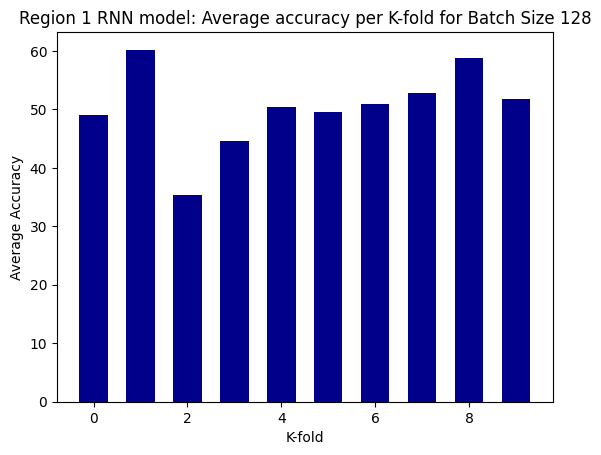

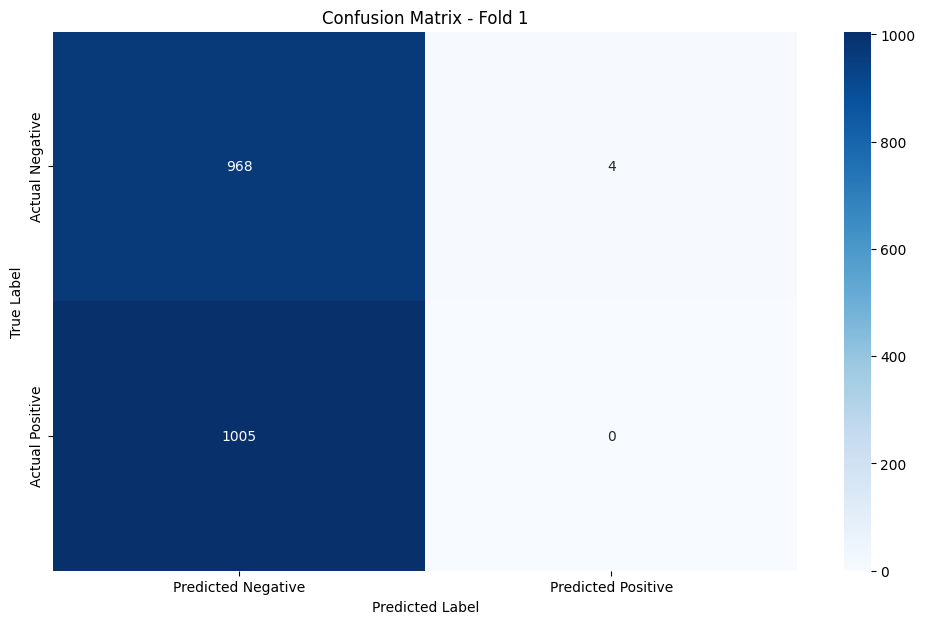

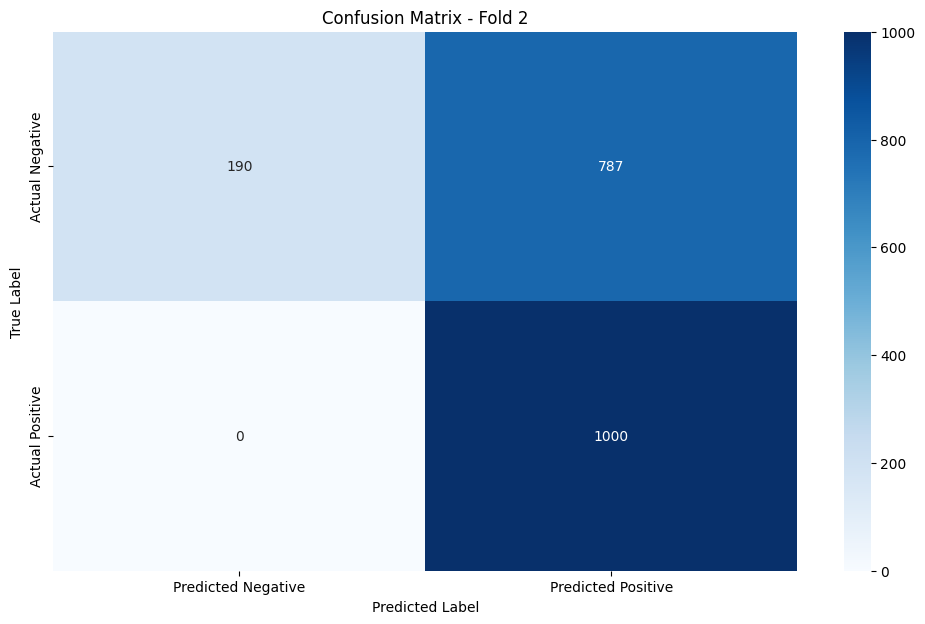

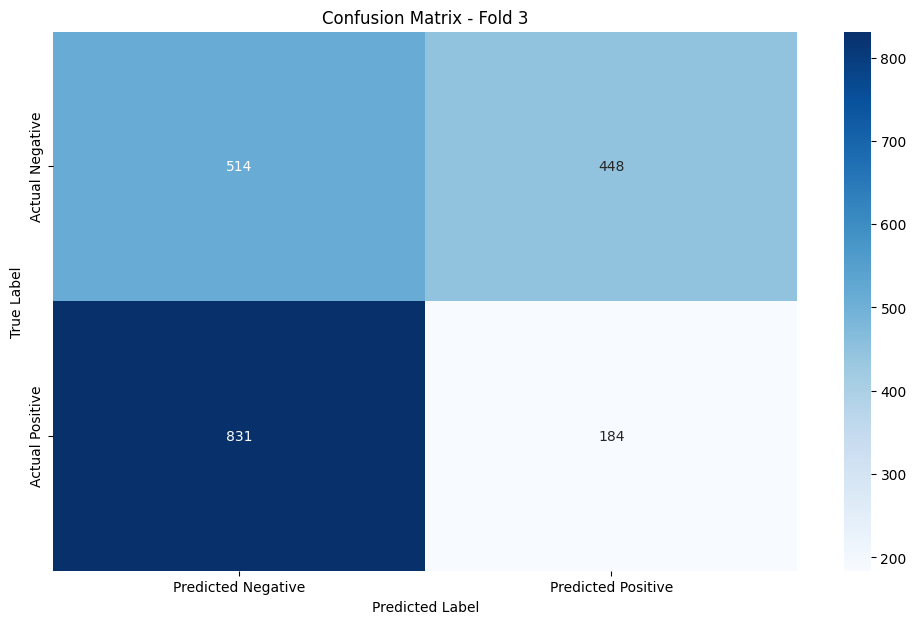

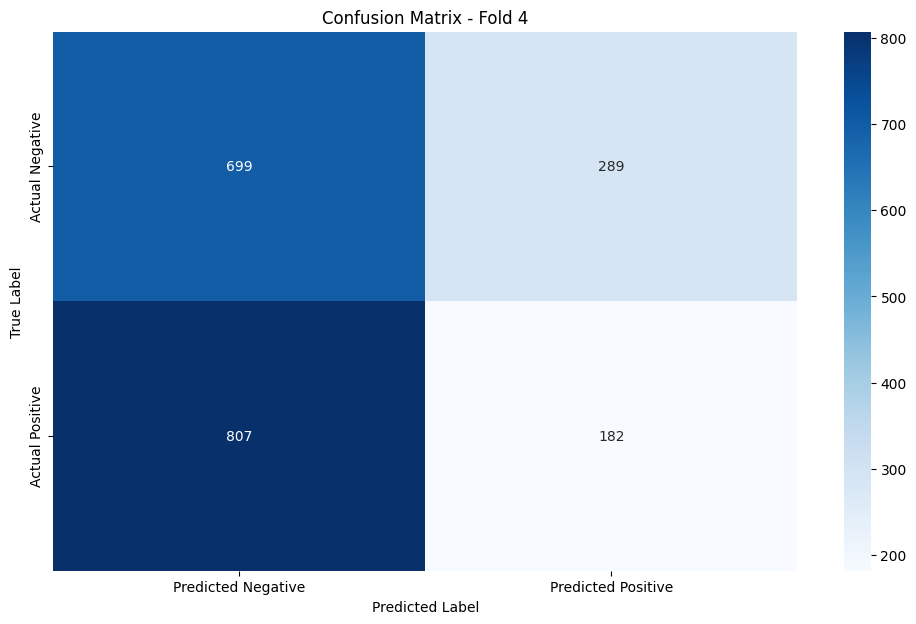

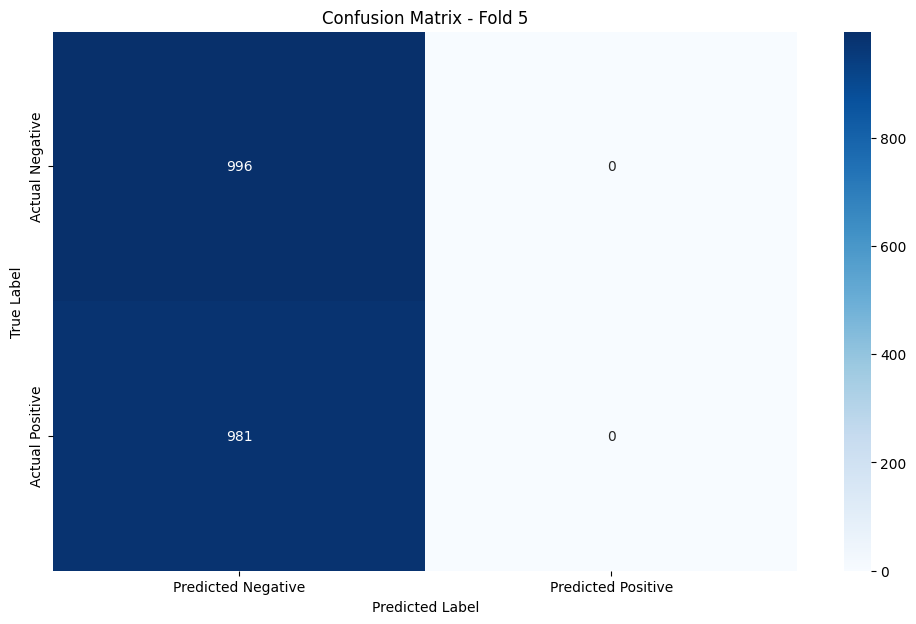

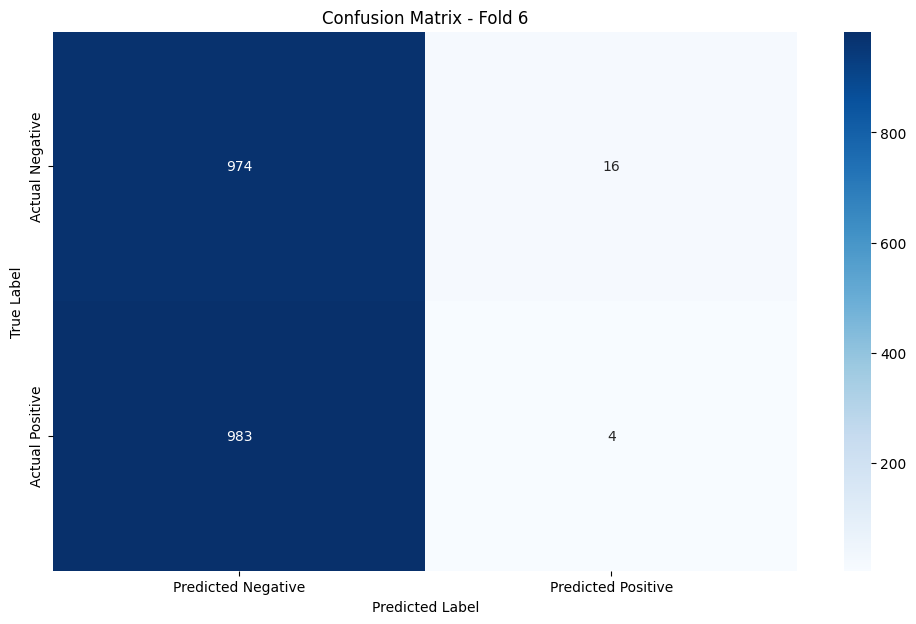

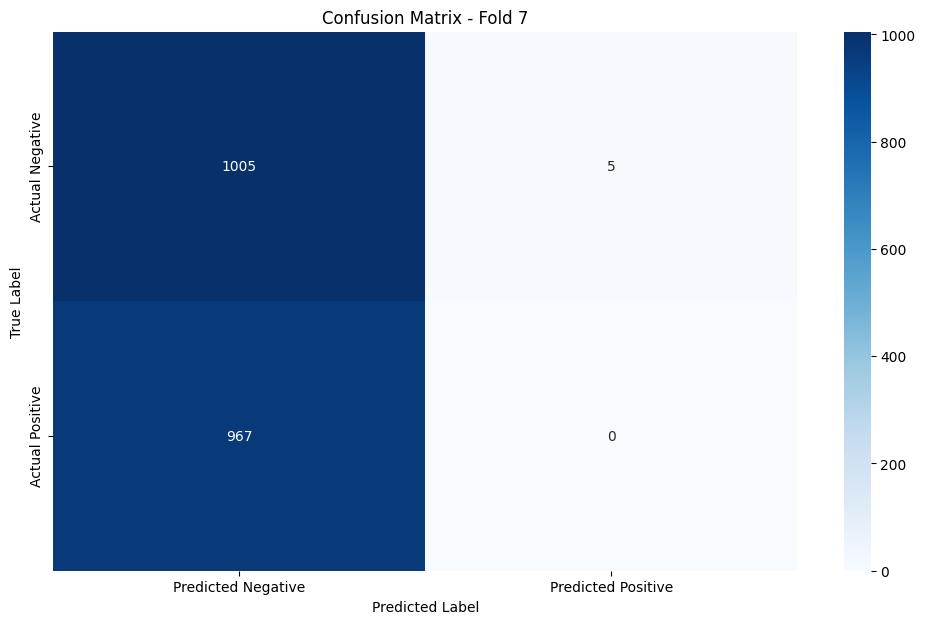

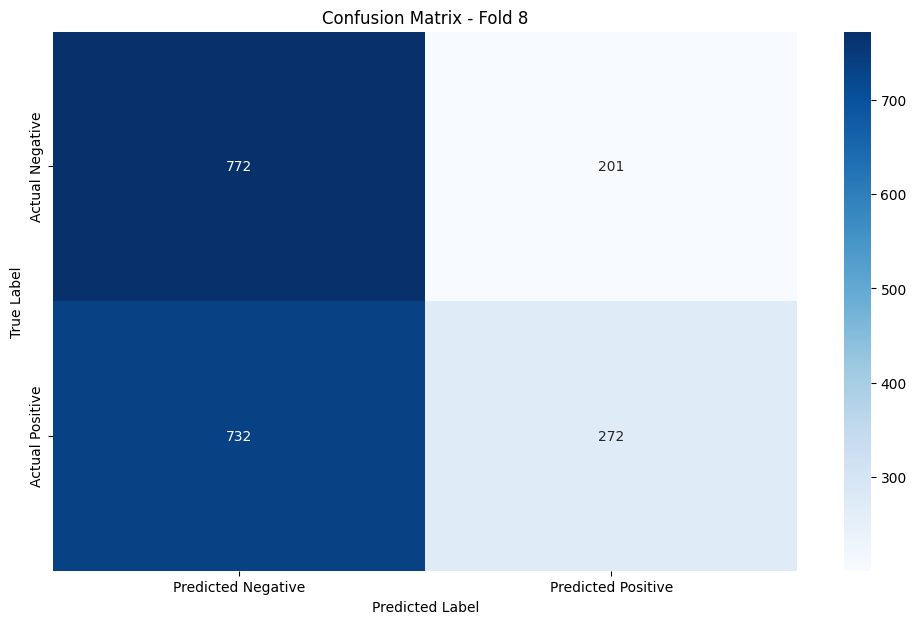

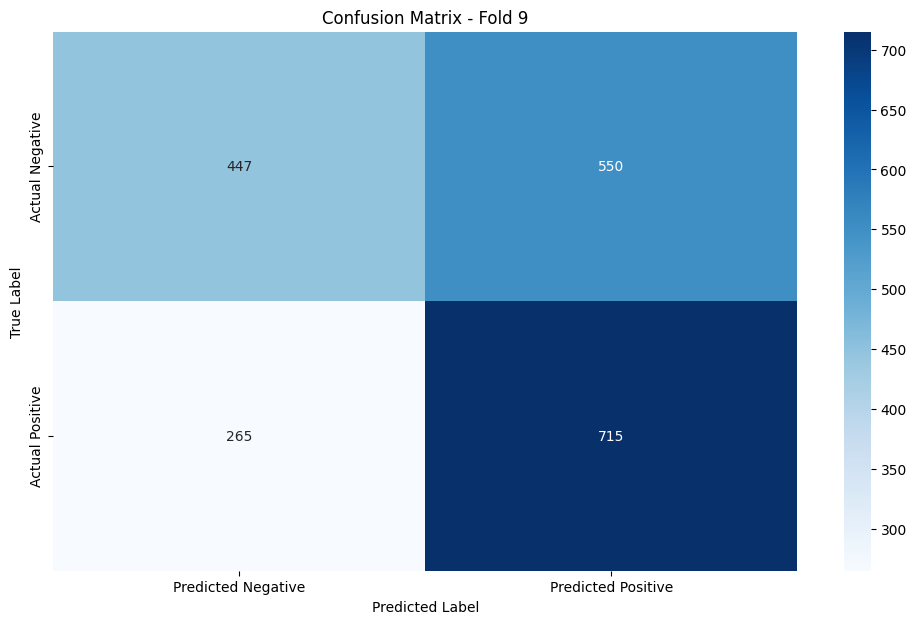

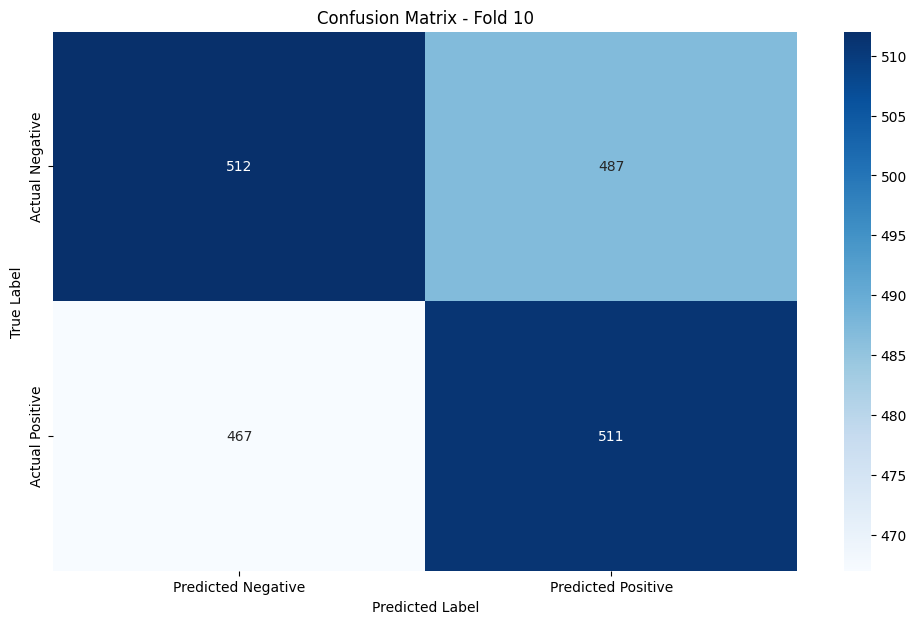

In [42]:
i = 0
for hexlist in best_hexid_per_kfold:
  new_hexlist = []
  for j in hexlist:
    temp = int(j)
    new_hexlist.append(temp)
  best_hexid_per_kfold[i] = new_hexlist
  i +=1

results = pd.DataFrame()
results['pred_y'] = best_all_pred_per_kfold[0][0]
results['actual_y'] = best_all_actual_per_kfold[0][0]
results

# model = NeuralNetwork()
# model.load_state_dict(torch.load("model.pth"))

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
confusion_per_k = []

for k in folds:
  mlcm = multilabel_confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
  print(f'=============== K = {k} ================')
  for cm in mlcm:
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]

    mcc = ((tn * tp) - (fn * fp)) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    f1 = tp / (tp + (0.5 * (fp + fn)))

  print(classification_report(best_actual_in_kfold[k], best_pred_in_kfold[k]))
  print('MCC: {}'.format(mcc))
  print('F1: {}'.format(f1))
    # if 0 accuracy is so bad, F1 is how much the predictions are right
    # might need to fix the amount under each label

def Average(lst):
  return sum(lst) / len(lst)

K = folds
# Get the index of the value 30
index_of_best_accuracy = batch_sizes.index(best_batch_size)

avg_accuracy = []
for i in outter_all_test_accuracy[index_of_best_accuracy]:
  avg = Average(i)
  avg_accuracy.append(avg)
print(avg_accuracy)

region = 1
plt.bar(K, avg_accuracy, color ='darkblue', width = 0.6)
plt.xlabel("K-fold")
plt.ylabel("Average Accuracy")
plt.title(f"Region {region} RNN model: Average accuracy per K-fold for Batch Size {best_batch_size}")
plt.show()

for k in folds:
    cf_matrix = confusion_matrix(best_actual_in_kfold[k], best_pred_in_kfold[k])
    # Plot confusion matrix
    plt.figure(figsize=(12, 7))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Predicted Negative', 'Predicted Positive'],
               yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - Fold {k+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Candidate sites
> This section aims to look for potential optimal locations to put up RHUs. We will call these locations candidate sites. We will use the Recursive Neural Network that was trained in the section above to find these locations.

#### keeping non buildable: The results show there are **1080 candidate sites**. Out of the 3305 locations, it was narrowed down to 32.7% (0.3267776096822995) of the region's low accessible areas. These can have RHU's placed on them.


## apply

In [43]:
modelpath = "/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG1/rnn_model.pt" # ⭐👑
candidatenn = RNN(input_size, hidden_size, output_size, batch_size).to(device)
candidatenn.load_state_dict(torch.load(modelpath))
candidatenn.eval()  # Set the model to evaluation mode

def low_k_fold_splitter(x,y,low_x,low_y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
  # actual labels for testing
  y_test = low_y
  x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)
  x_test_tensor = torch.tensor(low_x.values, dtype=torch.float)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
  y_test_tensor = torch.tensor(low_y.values, dtype=torch.long)

  # Splits X and Y tensors
  train_data = TrainData(x_train_tensor, y_train_tensor)
  test_data = TestData(x_test_tensor, y_test_tensor)

  # Data Loader
  BATCH_SIZE = best_batch_size # ✈️ GO BACK TO THIS NEXT SEM - something u can optimize pa
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)
  return train_loader, test_loader, x_test_tensor, y_test

# global all_train_loss
all_train_loss = []
# global all_test_average_loss_values
all_test_average_loss_values  = []
# global all_test_accuracy
all_test_accuracy = []
# global all_pred_per_kfold
all_pred_per_kfold = []
# global all_actual_per_kfold
all_actual_per_kfold = []
# global actual_in_kfold
actual_in_kfold = []
# global pred_in_kfold
pred_in_kfold = []
# global hexid_per_kfold
hexid_per_kfold = []
best_accuracy = 0.0
modelpatience =20  # Number of epochs with no improvement to wait before stopping

In [44]:
for k in folds:
  train_loader, test_loader, x_test_tensor, y_test = low_k_fold_splitter(x_normalized, y_sample, filtered_low_accessible_x, filtered_labels_y)
  test_loss_values = []
  test_average_loss_values = []
  test_accuracy_values = []
  counter = 0  # Counter for consecutive epochs with no improvement
  prev_val_loss = float('inf')  # Initialize previous validation loss
  prev_accuracy = 0.0            # Initialize previous accuracy
  epochs = 100 ## change to best epoch pls
  print(f"=================== K = {k+1} ===================\n")

  for epoch in range(epochs):
      train(k,epoch,train_loader, candidatenn, criterion, optimizer)
      val_loss, val_accuracy = test(k,epoch,test_loader, candidatenn, criterion)
      if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          counter = 0 # Reset counter if there's improvement
      else:
          counter += 1
      if counter >= modelpatience:
          print(f'No improvement for {modelpatience} consecutive epochs. Stopping early.')
          break

  # predictions = candidatenn(x_test_tensor)
  # predictions = F.softmax(predictions)
  # predictions = torch.argmax(predictions, dim=1)

  hidden_state = model.init_zero_hidden(batch_size=x_test_tensor.size(0))
  predictions, _ = model(x_test_tensor, hidden_state)
  predictions = F.softmax(predictions, dim=1)
  predictions = torch.argmax(predictions, dim=1)

  pred_in_kfold.append(predictions)
  actual_y = y_test # actual y values per k-fold
  all_train_loss.append(train_loss_values)# loss
  all_test_average_loss_values.append(test_average_loss_values)# loss
  all_test_accuracy.append(test_accuracy_values) # accuracy
  actual_in_kfold.append(actual_y) # y pred and actual y
  all_pred_per_kfold.append(pred_in_kfold) # y pred and actual y
  all_actual_per_kfold.append(actual_y.tolist()) # y pred and actual y

  print("Done!")

=================== K = 1 ===================

loss: 0.669459  [    0/ 4612]
Fold: 1 | Epoch 1: | Loss: 0.761 | Acc: 18.790
loss: 0.669334  [    0/ 4612]
Fold: 1 | Epoch 2: | Loss: 0.761 | Acc: 18.790
loss: 0.670879  [    0/ 4612]
Fold: 1 | Epoch 3: | Loss: 0.761 | Acc: 18.790
loss: 0.669934  [    0/ 4612]
Fold: 1 | Epoch 4: | Loss: 0.761 | Acc: 18.790
loss: 0.679494  [    0/ 4612]
Fold: 1 | Epoch 5: | Loss: 0.761 | Acc: 18.790
loss: 0.656341  [    0/ 4612]
Fold: 1 | Epoch 6: | Loss: 0.761 | Acc: 18.790
loss: 0.662226  [    0/ 4612]
Fold: 1 | Epoch 7: | Loss: 0.761 | Acc: 18.790
loss: 0.667145  [    0/ 4612]
Fold: 1 | Epoch 8: | Loss: 0.761 | Acc: 18.790
loss: 0.668302  [    0/ 4612]
Fold: 1 | Epoch 9: | Loss: 0.761 | Acc: 18.790
loss: 0.666756  [    0/ 4612]
Fold: 1 | Epoch 10: | Loss: 0.761 | Acc: 18.790
loss: 0.664857  [    0/ 4612]
Fold: 1 | Epoch 11: | Loss: 0.761 | Acc: 18.790
loss: 0.662750  [    0/ 4612]
Fold: 1 | Epoch 12: | Loss: 0.761 | Acc: 18.790
loss: 0.664893  [    0/ 46

## Candidate sites - Results

In [45]:
# results['hex_id'] = hexid_per_kfold[0]
results = pd.DataFrame()
results['pred_y'] = all_pred_per_kfold[0][0]
results['actual_y'] = all_actual_per_kfold[0][0]

# candidates = pd.concat([results, y_filtered_labels_id], axis=1)
# candidates = candidates.drop(['index'], axis=1)
results[results['pred_y'] == 1]

,pred_y,actual_y
0,1,0
1,1,0
2,1,0
3,1,0
5,1,0
...,...,...
3294,1,0
3295,1,0
3296,1,0
3297,1,0


In [46]:
y_filtered_labels_id

,ID,Cluster
0,2865422,0
1,2866789,0
2,2866790,0
3,2866791,0
4,2866795,0
...,...,...
4681,2991037,0
4682,2991038,0
4683,2991039,0
4690,2992397,0


In [47]:
# Reset index of both DataFrames
y_filtered_labels_id.reset_index(drop=True, inplace=True)
results.reset_index(drop=True, inplace=True)

# Merge the DataFrames side by side
merged_df = pd.concat([y_filtered_labels_id, results], axis=1)

# Display the merged DataFrame
print(merged_df)

           ID  Cluster  pred_y  actual_y
0     2865422        0       1         0
1     2866789        0       1         0
2     2866790        0       1         0
3     2866791        0       1         0
4     2866795        0       0         0
...       ...      ...     ...       ...
3300  2991037        0       0         0
3301  2991038        0       0         0
3302  2991039        0       0         0
3303  2992397        0       1         0
3304  2992418        0       0         0

[3305 rows x 4 columns]


In [48]:
candidates = merged_df[merged_df['pred_y'] == 1]
candidate_sites = candidates
len(candidate_sites)

1643

In [49]:
all = len(results)
print(all)
buildable = len(candidate_sites)
print(buildable)
build_rhu_landscape = buildable/all
build_rhu_landscape # this tells us how much of the area is a candidate site

3305
1643


0.49712556732223906

In [50]:
# Export the dataset
save_dir = "/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG1/"
hex_neighbors.to_csv(save_dir + '/Neighbors.csv', index=False)
candidate_sites.to_csv(save_dir + '/candidate_sites.csv', index=False)
filtered_low_accessible_df.to_csv(save_dir + '/PCF_data.csv', index=False)

# PCF calculations
**Goal:** Get the buildable areas with their populations
> *Criteria*:
- drop high accessible areas (Cluster == 1),
- drop areas with no population (population == 0) and
- areas with RHUs (rhu_presence == 1).

**Remember, we want to target areas with HIGH POPULATION and LIMITED to NO RHU ACCESS!**

#### ***Recommended number of facilities is 81 for Region 1.*** (removing non buildable sites.)
#### ***recommended number of facilities is 363 for Region 1.*** (Keeping the non buildable sites) < go to downsampling part in the code to modify this


In [ ]:
'''get the dataframe with the population density of the vulnerable population groups & general population
from the population density, use total = vp + (gp - vp) to get the total population density then convert it
using the (pd * la) to get the number of people in the hexagon'''

'''As of March 14, 2024, i cant do this yet bc i messed up the population during the data prep stage. I already
calculated the total population count while preprocessing the data before the HCFAI stage.. so im thinking the
hcfai values arent even right bc of this misstep.... lol fml hsjdkfhjsdh'''

''' On the bright side, all i have to do now is to rerun this notebook after changing the data in the data prep stage.'''
# rg1n_clustered_df.drop(rg1n_clustered_df.index[rg1n_clustered_df['Cluster'] == 1], inplace = True)
rg1n_clustered_df
# sablayan_clustered_df = sablayan_clustered_df.drop(['HCFAI_x'], axis=1)
# sablayan_clustered_df.rename(columns = {'HCFAI_y':'HCFAI'}, inplace = True)
rg1n_clustered_df['Cluster'].unique() # 0 nan
hex_with_rhu = rg1n_clustered_df[rg1n_clustered_df['RHU_Presence'] == 1]
hex_with_rhu
rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 1]

print(rg1n_clustered_df.shape)
print(rg1n_clustered_df['RHU_Presence'].unique())
print(rg1n_clustered_df['Cluster'].unique())
buildable = rg1n_clustered_df[rg1n_clustered_df['buildability_landcov'] == 1]
buildable

non_buildable.shape # (1857, 23)
buildable.shape # (2835, 23)

(4692, 24)
[0 1]
[0. 1.]


(2835, 24)

In [ ]:
high_clustered = buildable[buildable['Cluster'] == 1]
high_clustered[high_clustered['buildability_landcov'] == 1] # look for buildable areas in high clustered areas
high_clustered[high_clustered['buildability_landcov'] == 0] # look for non buildable areas in high clustered areas
high_clustered['buildability_landcov'].unique() # looking for unique values. If its one, all places in this df are buiildable for RHUs

# df with RHUs + df with buildable areas == SABLAYAN
# using this to compute for the total population
frames = [hex_with_rhu, rg1n_clustered_df]
rg1_PCF_df = pd.concat(frames)
rg1_PCF_df

,Unnamed: 0,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,...,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster,total_population
220,223,2877844,Arwas,Bani,Pangasinan,59.296404,51.271190,300.048330,114.580094,156.934760,...,1,1,1,0,2877844,0.000000,"2877844, 2877845, 2876462, 2877845, 2877844, 2...",0.567438,1.0,510.216338
274,278,2880597,Arnedo,Bolinao,Pangasinan,865.707140,524.250810,3529.817176,1252.451590,1738.954892,...,0,1,1,1,2880597,0.000000,"2880597, 2879215, 2880596, 2880597, 2880596, 2...",0.518090,0.0,5673.921032
796,808,2901348,Poblacion,Sual,Pangasinan,229.101720,115.704960,947.569080,352.020240,473.207400,...,1,1,1,1,2901348,0.000000,"2901348, 2901347, 2899967, 2899967, 2899966",0.605965,1.0,1766.679730
1089,1114,2919329,Bayaoas,Aguilar,Pangasinan,222.779118,119.541209,816.214631,298.288074,387.871912,...,0,1,1,1,2919329,0.000000,"2919329, 2917947, 2919329, 2917946, 2919328, 2...",0.491393,0.0,2153.744355
1348,1419,2928944,Lisqueb,Bacnotan,La Union,328.063958,392.244928,1944.965636,692.946373,1027.399395,...,0,1,1,1,2928944,0.000000,"2928944, 2928945, 2928945, 2928945, 2928945, 2...",0.486347,0.0,3334.559782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,5724,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0,16.540533
4688,5725,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0,9.480127
4689,5726,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0,6.607602
4690,5727,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0,0.943759


In [ ]:
rg1_PCF_df.reset_index(drop=True, inplace=True)
rg1_PCF_df.drop(columns=['Unnamed: 0'], inplace=True)
total_rgn1_population = 0
def PCF(total_population):
  PCF = total_population / 20000
  return int(PCF)

In [ ]:
a = 1.65 # or 13042??
pd = rg1_PCF_df['popden_all']
rg1_PCF_df['total_population'] = pd * a
rg1_PCF_df

,ID,barangay_name,city_name,province_name,popden_chi,popden_eld,popden_wom,popden_you,popden_w_1,popden_all,...,buildability_landcov,RHU_Presence,Road_Presence,POI_Presence,Nearest_RHU,Distance_to_Nearest_RHU_km,Neighbors,HCFAI,Cluster,total_population
0,2877844,Arwas,Bani,Pangasinan,59.296404,51.271190,300.048330,114.580094,156.934760,510.216338,...,1,1,1,0,2877844,0.000000,"2877844, 2877845, 2876462, 2877845, 2877844, 2...",0.567438,1.0,841.856958
1,2880597,Arnedo,Bolinao,Pangasinan,865.707140,524.250810,3529.817176,1252.451590,1738.954892,5673.921032,...,0,1,1,1,2880597,0.000000,"2880597, 2879215, 2880596, 2880597, 2880596, 2...",0.518090,0.0,9361.969703
2,2901348,Poblacion,Sual,Pangasinan,229.101720,115.704960,947.569080,352.020240,473.207400,1766.679730,...,1,1,1,1,2901348,0.000000,"2901348, 2901347, 2899967, 2899967, 2899966",0.605965,1.0,2915.021555
3,2919329,Bayaoas,Aguilar,Pangasinan,222.779118,119.541209,816.214631,298.288074,387.871912,2153.744355,...,0,1,1,1,2919329,0.000000,"2919329, 2917947, 2919329, 2917946, 2919328, 2...",0.491393,0.0,3553.678186
4,2928944,Lisqueb,Bacnotan,La Union,328.063958,392.244928,1944.965636,692.946373,1027.399395,3334.559782,...,0,1,1,1,2928944,0.000000,"2928944, 2928945, 2928945, 2928945, 2928945, 2...",0.486347,0.0,5502.023641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,2992394,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,16.540533,...,1,0,0,1,2971664,20.940640,2992394,0.545943,1.0,27.291880
4715,2992395,Pasaleng,Pagudpud,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,9.480127,...,1,0,0,1,2971664,20.940735,"2992395, 2991013, 2992394",0.545943,1.0,15.642209
4716,2992396,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,6.607602,...,1,0,0,1,2971664,21.033190,"2992396, 2991014, 2992396, 2991014, 2992395",0.576700,1.0,10.902543
4717,2992397,Adams (Pob.),Adams,Ilocos Norte,0.000000,0.000000,0.000000,0.000000,0.000000,0.943759,...,1,0,0,0,2971664,21.185258,"2992397, 2991015",0.529749,0.0,1.557203


In [ ]:
rg1_PCF_df.columns
# total_rgn1_population = rg1_PCF_df['popden_all'].sum()
total_rgn1_population = rg1_PCF_df['total_population'].sum()
print(round(total_rgn1_population, 2))
print(PCF(total_rgn1_population))

7270309.86
363
